In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.autograd import Variable
from torchvision import datasets, transforms
from model.wideVAE import *
from blackbox_pgd_model.wideresnet_update import *
from pgd_attack import *
import torch.optim as optim
import numpy as np
from util import *
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# parser = argparse.ArgumentParser(description='PyTorch CIFAR10 VAE Training')
# parser.add_argument('--batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--test-batch-size', type=int, default=200, metavar='N',
#                     help='input batch size for testing (default: 128)')
# parser.add_argument('--x-dim', type=int, default=784)
# parser.add_argument('--hidden-dim', type=int, default=400)
# parser.add_argument('--latent-dim', type=int, default=200)
# parser.add_argument('--epochs', type=int, default=30)
# args = parser.parse_args()
torch.manual_seed(1)
torch.cuda.manual_seed(1)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])
batch_size = 200
test_batch_size = 200
beta = 0.5
trainset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform_train)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, **kwargs)
testset = torchvision.datasets.CIFAR10(root='../data', train=False, download=True, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False, **kwargs)

def train(vae_model, c_model, data_loader, vae_optimizer, c_optimizer, epoch_num):
    vae_model.train()
    c_model.train()
    v_loss_sum = 0
    c_loss_sum = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        #data = data.view(batch_size, x_dim)
        data, target = data.to(device), target.to(device)
        vae_optimizer.zero_grad()
        c_optimizer.zero_grad()
        x_hat, mean, log_v, x_ = vae_model(data)
        # x_cat = torch.cat((mean, log_v),1)
        logit = c_model(x_.detach().view(-1,160,8,8))
        #logit = c_model(x_cat)
        v_loss, c_loss = loss_function_mean(data, target, x_hat, mean, log_v, logit)
        #print(loss)
        v_loss_sum += v_loss
        c_loss_sum += c_loss
        # if epoch_num % 2 == 1:
        if epoch_num <= 30:
            v_loss.backward()
            vae_optimizer.step()
            c_loss.backward()
        else:
            c_loss.backward()
            c_optimizer.step()
            v_loss.backward()
    return v_loss_sum, c_loss_sum

def eval_train(vae_model, c_model):
    vae_model.eval()
    c_model.eval()
    err_num = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            x_hat, mean, log_v, x_ = vae_model(data)
            logit = c_model(x_.detach().view(-1,160,8,8))
            err_num += (logit.data.max(1)[1] != target.data).float().sum()
    print('train error num:{}'.format(err_num))
def eval_test(vae_model, c_model):
    vae_model.eval()
    c_model.eval()
    err_num = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            x_hat, mean, log_v, x_ = vae_model(data)
            logit = c_model(x_.detach().view(-1,160,8,8))
            err_num += (logit.data.max(1)[1] != target.data).float().sum()
    print('test error num:{}'.format(err_num))


Files already downloaded and verified
Files already downloaded and verified


In [2]:
def testtime_update(vae_model, c_model, x_adv, target, learning_rate=0.1, num = 30, mode = 'mean'):
    x_adv = x_adv.detach()
    x_hat_adv, mean, log_v, x_ = vae_model(x_adv)
    for _ in range(num):
        if (x_hat_adv != x_hat_adv).sum() > 0:
            print('nan Error')
            exit()
        if mode == 'mean':
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, size_average=False, reduction='mean')
            # loss = vae_loss_mean(x_adv, x_hat_adv, mean, log_v)
        else:
            loss = nn.functional.binary_cross_entropy(x_hat_adv, x_adv, reduction='sum')
            # loss = vae_loss_sum(x_adv, x_hat_adv, mean, log_v)
        x_.retain_grad()
        loss.backward(retain_graph=True)
        with torch.no_grad():
            x_.data -= learning_rate * x_.grad.data
        x_.grad.data.zero_()
    x_hat_adv_new = vae_model.re_forward(x_)
    logit_adv = c_model(x_.view(-1,160,8,8))
        # print((logit_adv.data.max(1)[1] != target.data).float().sum())
    return logit_adv, x_hat_adv, x_hat_adv_new

In [69]:
def test(vae_model, c_model, source_model):
    err_num = 0
    err_adv = 0
    c_model.eval()
    vae_model.eval()
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data = Variable(data.data, requires_grad=True)
        x_hat,_,_,x_ = vae_model(data)
        logit = c_model(x_.view(-1,160,8,8))
        err_num += (logit.data.max(1)[1] != target.data).float().sum()
        x_adv = pgd_cifar_blackbox(vae_model, c_model, source_model, data, target, 20, 0.03, 0.003)
        # x_adv = pgd_cifar(vae_model, c_model, data, target, 20, 0.03, 0.003)
        logit_adv, x_hat_adv, x_hat_adv_new = testtime_update(vae_model, c_model,  x_adv, target,learning_rate=0.01, num=200)
        return data, x_hat, x_adv, x_hat_adv, x_hat_adv_new, target
        # logit_adv = diff_update_cifar(vae_model,c_model, x_adv, target,learning_rate=0.05, num=500)
        # _,_,_,x_adv_ = vae_model(x_adv)
        # logit_adv = c_model(x_adv_.view(-1,160,8,8))
        # logit = c_model(x_.view(-1,160,8,8))
        adv_num = (logit_adv.data.max(1)[1] != target.data).float().sum()
        # exit()
        print(adv_num)
        err_adv += adv_num
        # x_cat_adv = torch.cat((m_adv, log_adv), 1)
        # logit_adv = c_model(x_cat_adv)
        # err_adv += (logit_adv.data.max(1)[1] != target.data).float().sum()
    print(len(test_loader.dataset))
    print(err_num)
    print(err_adv)

In [31]:
def model_pred(vae_model, c_model,x):
    _,_,_,x_ = vae_model(x)
    logit = c_model(x_.view(-1,160,8,8))
    return logit.data.max(1)[1]

In [32]:
def adjust_learning_rate(optimizer, epoch, lr):
    """decrease the learning rate"""
    lr_ = lr
    if epoch >= 80:
        lr_ = lr * 0.1
    if epoch >= 90:
        lr_ = lr * 0.01
    if epoch >= 100:
        lr_ = lr * 0.001
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr_
    

In [35]:
source_model = WideResNet().to(device)
source_model_path = './blackbox_pgd_model/model-wideres-epoch76.pt'
vae_model = wide_VAE(zDim=256).to(device)
c_model = classifier().to(device)
vae_model_path = './model-checkpoint/cifar-vae-model-89.pt'
c_model_path = './model-checkpoint/cifar-c-model-89.pt'
source_model.load_state_dict(torch.load(source_model_path))
vae_model.load_state_dict(torch.load(vae_model_path))
c_model.load_state_dict(torch.load(c_model_path))

<All keys matched successfully>

In [ ]:

# lr = 0.001
# epochs = 90
# vae_model = wide_VAE(zDim=256).to(device)
# vae_optimizer = optim.Adam(vae_model.parameters(), lr=lr)
# c_model = classifier().to(device)
# c_optimizer = optim.Adam(c_model.parameters(), lr=lr*10)
# print(len(train_loader.dataset))
# for epoch in range(1, epochs+1):
#     adjust_learning_rate(c_optimizer, epoch, lr*10)
#     v_loss, c_loss = train(vae_model,c_model, train_loader, vae_optimizer, c_optimizer, epoch)
#     print('Epoch {}: VAE Average loss: {:.6f}'.format(epoch, v_loss/len(train_loader.dataset)))
#     print('Epoch {}: Classifier Average loss: {:.6f}'.format(epoch, c_loss/len(train_loader.dataset)))
# test(vae_model, c_model)

In [36]:
import matplotlib.pyplot as plt
def show_image(x, idx):
    x = x.view(test_batch_size,3, 32, 32)
    # x = x.detach().cpu().numpy()
    # x = x.transpose(0,2,3,1).astype("uint8")
    fig = plt.figure()
    plt.imshow(transforms.ToPILImage()(x[idx]))

In [70]:
x, x_hat, x_adv, x_hat_adv, x_hat_new, target = test(vae_model, c_model, source_model)
logit_nat = model_pred(vae_model,c_model,x)
logit_adv = model_pred(vae_model,c_model,x_adv)
logit_hat_adv = model_pred(vae_model,c_model,x_hat_adv)
logit_hat_new = model_pred(vae_model,c_model,x_hat_new)

In [71]:
(logit_nat != target).sum()

tensor(38, device='cuda:0')

In [72]:
(logit_adv!= target).sum()

tensor(69, device='cuda:0')

In [73]:
(logit_hat_adv!= target).sum()

tensor(78, device='cuda:0')

In [74]:
(logit_hat_new!= target).sum()

tensor(74, device='cuda:0')

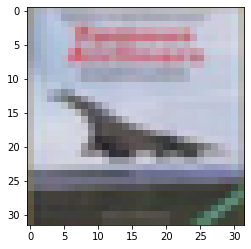

In [75]:
idex = 3
show_image(x, idx=idex)

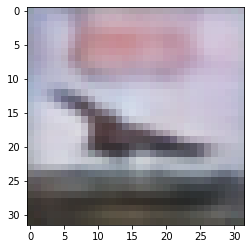

In [76]:
show_image(x_hat, idx=idex)

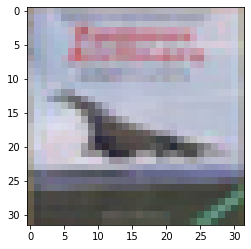

In [77]:
show_image(x_adv, idx=idex)

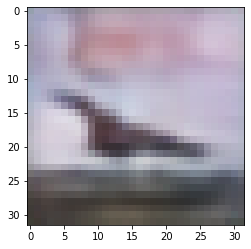

In [78]:
show_image(x_hat_adv, idx=idex)

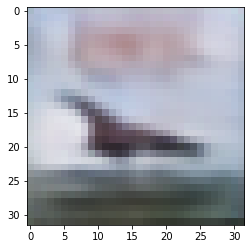

In [79]:
show_image(x_hat_new, idx=idex)

In [3]:
vae_model = wide_VAE(zDim=256).to(device)
vae_optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
c_model = classifier().to(device)
c_optimizer = optim.Adam(c_model.parameters(), lr=0.01)
print('testing mode')
model_dir = './model-checkpoint'
test_num = 90
vae_model_path = '{}/cifar-vae-model-{}.pt'.format(model_dir, test_num)
c_model_path = '{}/cifar-c-model-{}.pt'.format(model_dir, test_num)
vae_model.load_state_dict(torch.load(vae_model_path))
c_model.load_state_dict(torch.load(c_model_path))
c_model.eval()
vae_model.eval()
for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data = Variable(data.data, requires_grad=True)
    # logit = model_pred(data, vae_model, c_model)
    # err_num += (logit.data.max(1)[1] != target.data).float().sum()
    # x_adv = pgd(vae_model, c_model, data, target, 20, 0.03, 0.003)
    # x_ = testtime_update(vae_model, x_adv ,learning_rate=0.15, num=100)
    _,_,_,x_ = vae_model(data)
    logit = c_model(x_.view(-1,160,8,8))
    break

testing mode
